In [1]:
#ipython magic
%reset -f
# change inline to notebook to get interactive (but slow) plots
%matplotlib inline 
%load_ext autoreload
%autoreload 2

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [2]:
# general imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
## put your path to your vape repo here 
path_to_vape = '/home/jamesrowland/Documents/Code/Vape/'
sys.path.append(path_to_vape)
sys.path.append(os.path.join(path_to_vape, 'utils'))

In [4]:
# notebook specific imports
import pickle
import utils_funcs as utils
import re

In [5]:
# global plotting params
sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'lines.markersize': 15}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)


In [6]:
def trial_outcomes(outcome):

    go_outcome = []
    nogo_outcome = []

    for t in outcome:
        if t == 'hit':
            go_outcome.append(True)
        elif t == 'miss':
            go_outcome.append(False)
        elif t =='cr':
            nogo_outcome.append(False)
        elif t == 'fp':
            nogo_outcome.append(True)

    go_outcome = np.array(go_outcome)
    nogo_outcome = np.array(nogo_outcome)
    
    return go_outcome, nogo_outcome

In [7]:
def get_subset_dprime(run):

    go_outcome, nogo_outcome = trial_outcomes(run.outcome)
    trial_subsets = []

    for i, info in enumerate(run.trial_info):
        if 'Nogo Trial' in info:
            continue
        elif 'all_cells_stimulated' in info:
            trial_subsets.append(150)
        elif 'Subset cells experiment' in info:
            trial_subset = int(re.search('(?<=stimulating )(.*)(?= cells)', info).group(0))
            trial_subsets.append(trial_subset)

    trial_subsets = np.array(trial_subsets)
    subsets = np.sort(np.unique(trial_subsets))
        
    fp_rate = sum(nogo_outcome) / len(nogo_outcome)
    
    subset_outcome = []

    for sub in subsets:
        subset_idx = np.where(trial_subsets == sub)[0]
        if len(subset_idx) < 10:
            subset_outcome.append(np.nan)
        else:
            subset_outcome.append(sum(go_outcome[subset_idx]) / len(subset_idx))

    subsets_dprime = [utils.d_prime(outcome, fp_rate) for outcome in subset_outcome]
    
    return subsets, subsets_dprime
    

In [8]:
mouse_id = 'J048'
run_numbers = [27,28,29]

# mouse_id = 'RL048'
# run_numbers = [23,24,25]

across_sessions = []

for run_number in run_numbers:

    pkl_path = os.path.join(path_to_vape, 'run_pkls', mouse_id, 'run{}.pkl'.format(run_number))

    with open(pkl_path, 'rb') as f:
        run = pickle.load(f)
        
    subsets, subsets_dprime = get_subset_dprime(run)
    
    across_sessions.append(subsets_dprime)
    
across_sessions = np.array(across_sessions)    

In [9]:
meaned = np.nanmean(across_sessions, 0)

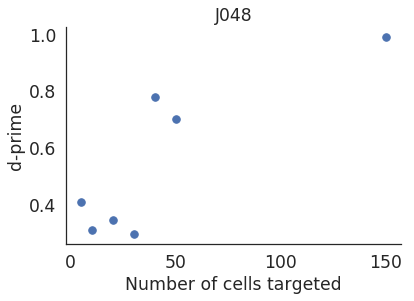

In [10]:
plt.plot(subsets, meaned, '.')
plt.xlabel('Number of cells targeted')
plt.ylabel('d-prime')
plt.title(mouse_id)
plt.savefig(os.path.join(path_to_vape, 'figures', '{}_easytest-dprime.png'.format(mouse_id)),  bbox_inches="tight")